# Forecasting, hierarchical data, tuning, and more

## Introduction

In this notebook, we will cover more advanced forecasting topics, specially focused on hierarchical data, tuning, and reconciliation.
We will use sales data from [this kaggle dataset](https://www.kaggle.com/datasets/utathya/future-volume-prediction?resource=download), which contains sales data for different products (SKUs) and agencies.

## Agenda

1. Simple forecasting with builtin parallelization
2. Reconciliation
3. Tuning with Optuna
4. Advanced patterns in hierarchical forecasting
5. Benchmarking


In [1]:
import warnings
import logging

warnings.filterwarnings("ignore")
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.ERROR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading and preparing the data

The dataset is a 3-level hierarchical time series, with the following levels:

1. Total sales for all SKUs and agencies
2. Sales for each agency
3. Sales for each SKU in each agency


![hierarchy diagram](img/mermaid_hierarchy.png)

In sktime, we use pandas multiindex to represent the hierarchy, where each level in the index represent a level in the hierarchy. The last level is reserved to the time index.

In [3]:
from utils import load_stallion

_, y = load_stallion(as_period=True)
y

volume
agency    sku    date            
Agency_01 SKU_01 2013-01   80.676
                 2013-02   98.064
                 2013-03  133.704
                 2013-04  147.312
                 2013-05  175.608
...                           ...
Agency_60 SKU_23 2017-08    1.980
                 2017-09    1.260
                 2017-10    0.990
                 2017-11    0.090
                 2017-12    2.250

[21000 rows x 1 columns]

### Aggregating the data

Since the dataset do not come with totals for each level, we will need to add them.
It can be easily done with `Aggregator` transformer from sktime.

In [4]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y = Aggregator().fit_transform(y)
y

volume
agency    sku     date                  
Agency_01 SKU_01  2013-01      80.676000
                  2013-02      98.064000
                  2013-03     133.704000
                  2013-04     147.312000
                  2013-05     175.608000
...                                  ...
__total   __total 2017-08  599553.665250
                  2017-09  556966.701300
                  2017-10  542554.007475
                  2017-11  457914.412950
                  2017-12  553316.088000

[24540 rows x 1 columns]

### Some useful pandas multiindex operations

Multiindex is a powerful tool in pandas, and knowing its operations can be very useful when working with hierarchical data.

In [5]:
y.index

MultiIndex([('Agency_01',  'SKU_01', '2013-01'),
            ('Agency_01',  'SKU_01', '2013-02'),
            ('Agency_01',  'SKU_01', '2013-03'),
            ('Agency_01',  'SKU_01', '2013-04'),
            ('Agency_01',  'SKU_01', '2013-05'),
            ('Agency_01',  'SKU_01', '2013-06'),
            ('Agency_01',  'SKU_01', '2013-07'),
            ('Agency_01',  'SKU_01', '2013-08'),
            ('Agency_01',  'SKU_01', '2013-09'),
            ('Agency_01',  'SKU_01', '2013-10'),
            ...
            (  '__total', '__total', '2017-03'),
            (  '__total', '__total', '2017-04'),
            (  '__total', '__total', '2017-05'),
            (  '__total', '__total', '2017-06'),
            (  '__total', '__total', '2017-07'),
            (  '__total', '__total', '2017-08'),
            (  '__total', '__total', '2017-09'),
            (  '__total', '__total', '2017-10'),
            (  '__total', '__total', '2017-11'),
            (  '__total', '__total', '2017-12')],
   

In [6]:
y.loc[("Agency_01", "SKU_01")].head()

,volume
date,
2013-01,80.676
2013-02,98.064
2013-03,133.704
2013-04,147.312
2013-05,175.608


In [7]:
y.index.get_level_values(0)

Index(['Agency_01', 'Agency_01', 'Agency_01', 'Agency_01', 'Agency_01',
       'Agency_01', 'Agency_01', 'Agency_01', 'Agency_01', 'Agency_01',
       ...
       '__total', '__total', '__total', '__total', '__total', '__total',
       '__total', '__total', '__total', '__total'],
      dtype='object', name='agency', length=24540)

In [8]:
y.loc[pd.IndexSlice[:, "SKU_01"],].head()

volume
agency    sku    date            
Agency_01 SKU_01 2013-01   80.676
                 2013-02   98.064
                 2013-03  133.704
                 2013-04  147.312
                 2013-05  175.608

In [9]:
y.index.get_level_values(-1)

PeriodIndex(['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
             '2013-07', '2013-08', '2013-09', '2013-10',
             ...
             '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
             '2017-09', '2017-10', '2017-11', '2017-12'],
            dtype='period[M]', name='date', length=24540)

In [10]:
y.index.droplevel(-1).unique()

MultiIndex([('Agency_01',  'SKU_01'),
            ('Agency_01',  'SKU_02'),
            ('Agency_01',  'SKU_03'),
            ('Agency_01',  'SKU_04'),
            ('Agency_01',  'SKU_05'),
            ('Agency_01',  'SKU_11'),
            ('Agency_01', '__total'),
            ('Agency_02',  'SKU_01'),
            ('Agency_02',  'SKU_02'),
            ('Agency_02',  'SKU_03'),
            ...
            ('Agency_59', '__total'),
            ('Agency_60',  'SKU_01'),
            ('Agency_60',  'SKU_02'),
            ('Agency_60',  'SKU_03'),
            ('Agency_60',  'SKU_04'),
            ('Agency_60',  'SKU_05'),
            ('Agency_60',  'SKU_07'),
            ('Agency_60',  'SKU_23'),
            ('Agency_60', '__total'),
            (  '__total', '__total')],
           names=['agency', 'sku'], length=409)

### Train-test split and visualization

In [11]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=18)

test_fh = y_test.index.get_level_values(-1).unique()
test_fh

PeriodIndex(['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
            dtype='period[M]', name='date')

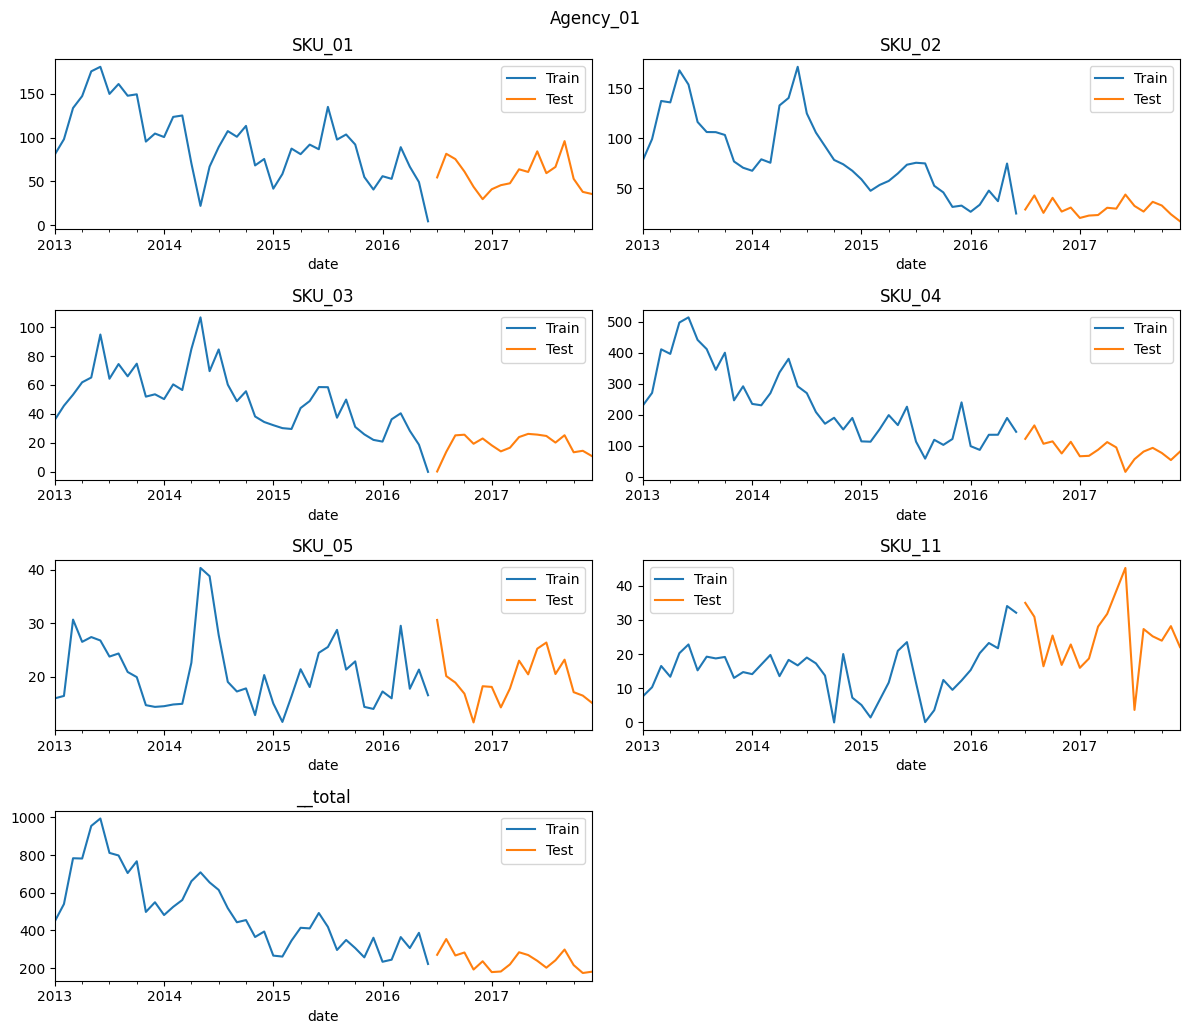

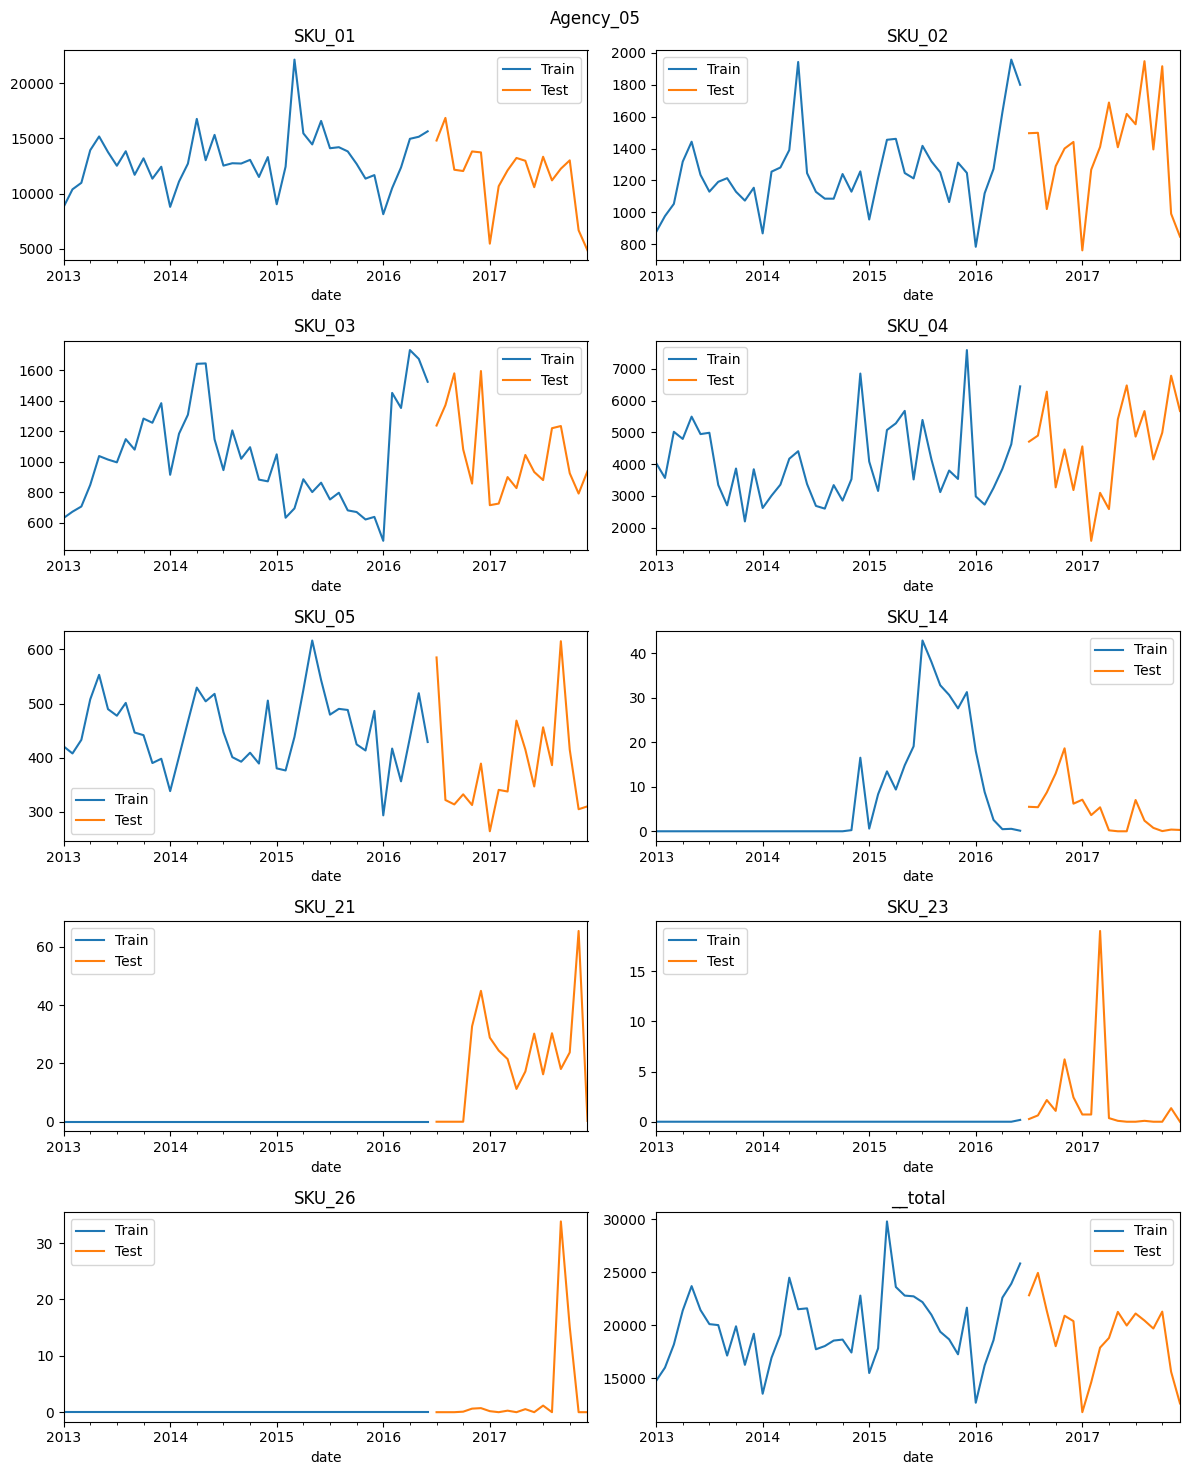

In [12]:
from utils import plot_series_for_given_level

plot_series_for_given_level("Agency_01", y_train, y_test)
plot_series_for_given_level("Agency_05", y_train, y_test)

## 1. Upcasting and Parallelization

Instead of needing to manually iterate over the series, we can use the builtin parallelization to handle this 🙂.

When a univariate forecasting model is fitted to a hierarchical time series, one model copy is created for each series in the hierarchy and fitted separately. All models share the same hyperparameter.

In [13]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.fbprophet import Prophet

import logging

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

### Upcasting without parallelization

In [14]:
# Warning: this cell may take 1-2 minutes to run!
model = Prophet()

model.fit(y_train)
model.predict(fh=test_fh)

Importing plotly failed. Interactive plots will not work.


volume
agency    sku     date                  
Agency_01 SKU_01  2016-07      34.567985
                  2016-08      82.860599
                  2016-09      62.245607
                  2016-10      76.752518
                  2016-11      13.102124
...                                  ...
__total   __total 2017-08  549434.608090
                  2017-09  485786.212891
                  2017-10  522701.769572
                  2017-11  474188.136735
                  2017-12  606215.239904

[7362 rows x 1 columns]

### With parallelization

Since this set of models is independent, we can fit them in parallel, which can be done by setting the config before calling fit.

**Warning**: if the model you are using already uses joblib, the parallelization won't work.

In [15]:
parallel_config = {
        "backend:parallel": "joblib",
        "backend:parallel:params": {"backend": "loky", "n_jobs": -1},
    }

In [16]:
model = Prophet()

model.set_config(**parallel_config)

model.fit(y_train)

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Prophet()

You can define more specific parallelization configurations, and use dask for example. Check the [docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.base.BaseForecaster.html#sktime.forecasting.base.BaseForecaster.set_config) for more information.

In [17]:
y_pred = model.predict(fh=test_fh)
y_pred

volume
agency    sku     date                  
Agency_01 SKU_01  2016-07      34.567985
                  2016-08      82.860599
                  2016-09      62.245607
                  2016-10      76.752518
                  2016-11      13.102124
...                                  ...
__total   __total 2017-08  549434.608090
                  2017-09  485786.212891
                  2017-10  522701.769572
                  2017-11  474188.136735
                  2017-12  606215.239904

[7362 rows x 1 columns]

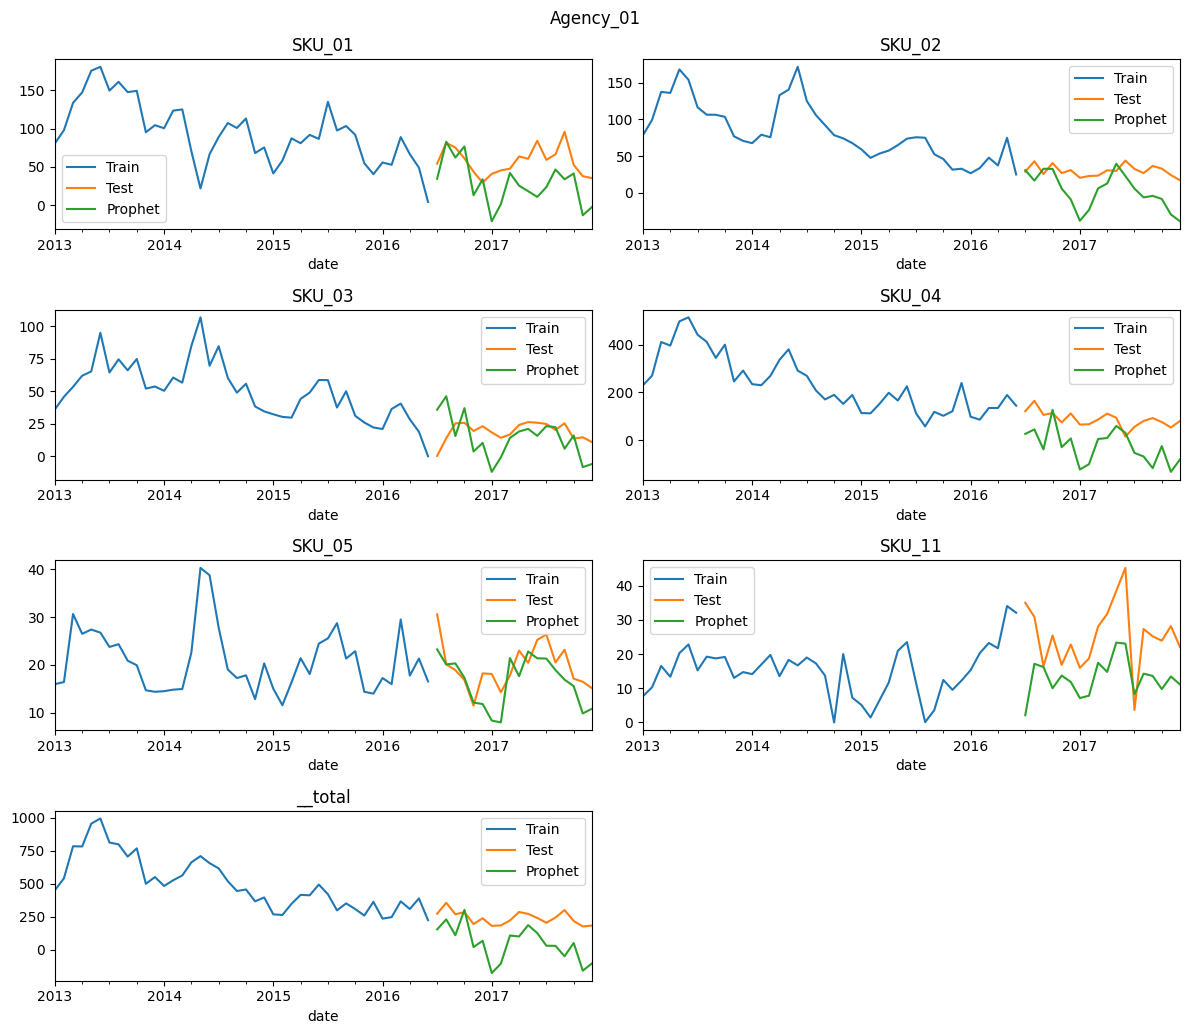

In [18]:
plot_series_for_given_level("Agency_01", y_train, y_test, {"Prophet" : y_pred})

After fitting, we can easily access fitted models and their parameters using `get_fitted_params`. The inner forecasters are stored in pandas dataframe in a structure similar to the timeseries.

In [19]:
fitted_params = model.get_fitted_params()
fitted_params["forecasters"]

forecasters
Agency_01 SKU_01    Prophet()
          SKU_02    Prophet()
          SKU_03    Prophet()
          SKU_04    Prophet()
          SKU_05    Prophet()
...                       ...
Agency_60 SKU_05    Prophet()
          SKU_07    Prophet()
          SKU_23    Prophet()
          __total   Prophet()
__total   __total   Prophet()

[409 rows x 1 columns]

## 2. Reconciliation

A common problem in hierarchical forecasting in obtaining a `coherent` forecast to share. Probably, your forecasts won't be _coherent_ with respect to the hierarchy. If we take the sum of the bottom levels, it won't be equal to our total forecast.


In [20]:
def get_difference_between_total_and_bottom_up(y_pred):
    bottom_up = (
        Aggregator().fit_transform(y_pred).loc[("__total", "__total"), "volume"]
    )
    total_forecast = y_pred.loc[("__total", "__total"), "volume"]
    difference = total_forecast - bottom_up
    return difference

get_difference_between_total_and_bottom_up(y_pred).head()

date
2016-07    502.738342
2016-08    301.235338
2016-09    714.930187
2016-10     92.113045
2016-11    361.216885
Freq: M, Name: volume, dtype: float64


This difference means two things:

1. By definition, one of them is wrong.
2. The users of the forecasts will be confused.

There are, fortunately, techniques to fix this. We call them `reconciliation` techniques and they are easy to use in sktime.


In [21]:
from sktime.transformations.hierarchical.reconcile import Reconciler

reconciler = Reconciler()
y_pred_reconciled = reconciler.fit_transform(y_pred)
y_pred_reconciled.head()

volume
agency    sku    date              
Agency_01 SKU_01 2016-07  34.567985
                 2016-08  82.860599
                 2016-09  62.245607
                 2016-10  76.752518
                 2016-11  13.102124

In [22]:
get_difference_between_total_and_bottom_up(y_pred_reconciled).head()

date
2016-07   -3.492460e-10
2016-08    0.000000e+00
2016-09   -5.820766e-11
2016-10    1.164153e-10
2016-11    0.000000e+00
Freq: M, Name: volume, dtype: float64

### How does reconciliation work?


* The hierarchy constrains are a set of linear constraints, and the `coherent` forecasts actually lie in a hyperplane defined by these constraints

* The general idea is to project the base forecasts onto this hyperplane.

* This generates a new forecast that can improve base ones by sharing information across nodes.


In [23]:
Reconciler(method="bu").fit_transform(y_pred)
Reconciler(method="ols").fit_transform(y_pred)
Reconciler(method="wls_str").fit_transform(y_pred)
Reconciler(method="td_fcst").fit_transform(y_pred)

volume
agency    sku     date                  
Agency_01 SKU_01  2016-07      34.112917
                  2016-08      82.065415
                  2016-09      61.643533
                  2016-10      76.026607
                  2016-11      12.675995
...                                  ...
__total   __total 2017-08  549434.608090
                  2017-09  485786.212891
                  2017-10  522701.769572
                  2017-11  474188.136735
                  2017-12  606215.239904

[7362 rows x 1 columns]

### Optimal reconciliation

And we can use `ReconcilerForecaster` to do more advanced reconciliation, using `mint_shrink`, `mint_cov` or `wls_var` methods, that consider the errors of each model to adjust the forecasts.

Disadvantages:

* May be unstable when there are constant series
* May not respect positivity constraints if this is important for your application

In [24]:
from sktime.forecasting.reconcile import ReconcilerForecaster
from sktime.forecasting.naive import NaiveForecaster

reconciler_model = ReconcilerForecaster(
    forecaster=Prophet().set_config(**parallel_config),
    method="mint_shrink",
)

reconciler_model.fit(y_train)

ReconcilerForecaster(forecaster=Prophet())

In [25]:
reconciler_model.get_fitted_params(deep=False)

{'forecaster': Prophet(),
 'residuals':                                  volume
 agency    sku     date                 
 Agency_01 SKU_01  2013-01    -10.362352
                   2013-02    -15.338475
                   2013-03    -20.481117
                   2013-04      9.760680
                   2013-05     45.244104
 ...                                 ...
 __total   __total 2016-02   -691.888446
                   2016-03  14099.675414
                   2016-04   -440.462063
                   2016-05  -5485.492734
                   2016-06  -1368.821026
 
 [17178 rows x 1 columns]}

## 3. Tuning hyperparameters with Optuna

* Optuna is a hyperparameter optimization framework that supports many sampling strategies. 
* Default is Tree of Parzen Estimators (TPE), which is a Bayesian-like optimization algorithm.
* Sktime also has implemented grid search, randomized search, skopt interface.

In [26]:
# The tuner forecaster
from sktime.forecasting.model_selection import ForecastingOptunaSearchCV
# The cross-validation strategy for the tuner
from sktime.split import ExpandingWindowSplitter
# Optuna interface for defining the search space
from optuna.distributions import (
    CategoricalDistribution
)

First, we need to define with cross validation strategy we will use to evaluate the models. In this case, we will use `ExpandingWindowSplitter`.

In [27]:
cv = ExpandingWindowSplitter(fh=[1, 2, 3, 4], initial_window=36, step_length=24)

Then, create the tuning forecaster, by passing the model and the parameter grid. The number of evaluations can be defined with `n_evals` parameter.

In [28]:
# Warning! This cell may take 1-2 min to run
tuning_model = ForecastingOptunaSearchCV(
    forecaster= Prophet().set_config(**parallel_config) * Reconciler(),
    param_grid={
        "method": CategoricalDistribution(["ols", "bu"]),
    },
    cv=cv,
    n_evals=2,
    error_score="raise",
)

tuning_model.fit(y_train)

[I 2024-08-26 17:30:19,580] A new study created in memory with name: no-name-d5fcf811-9a4d-42ce-b2f0-2b1f0cbdf83d


ForecastingOptunaSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4],
                                                     initial_window=36,
                                                     step_length=24),
                          error_score='raise',
                          forecaster=TransformedTargetForecaster(steps=[Prophet(),
                                                                        Reconciler()]),
                          n_evals=2,
                          param_grid={'method': CategoricalDistribution(choices=('ols', 'bu'))})

In [29]:
fitted_params = tuning_model.get_fitted_params(deep=False)
fitted_params["cv_results"]

,number,mean_test_MeanAbsolutePercentageError,datetime_start,datetime_complete,duration,params_method,state,params,rank_test_MeanAbsolutePercentageError
0,0,1.806906e+16,2024-08-26 17:30:19.581289,2024-08-26 17:30:34.436703,0 days 00:00:14.855414,ols,COMPLETE,{'method': 'ols'},2.0
1,1,9.184535e+14,2024-08-26 17:30:34.436773,2024-08-26 17:30:50.172886,0 days 00:00:15.736113,bu,COMPLETE,{'method': 'bu'},1.0


In [30]:

fitted_params["best_params"]

{'method': 'bu'}

In [31]:
best_forecaster = fitted_params["best_forecaster"]
best_forecaster

TransformedTargetForecaster(steps=[Prophet(), Reconciler()])

## 4. Advanced patterns in hierarchical forecasting

Tuning a different model for each hierarchy level.

In [32]:
warnings.filterwarnings("ignore")

In [33]:
from sktime.forecasting.compose import HierarchyEnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA


ensemble_by_level = HierarchyEnsembleForecaster(
    # We pass a tuple of (name, forecaster, level) for each level
    # The name could be anything, but it should be unique
    forecasters=[("total", Prophet(), 0),
                 ("agency", AutoARIMA(), 1),
                 ("sku", ExponentialSmoothing(), 2)],
    by="level",
)

ensemble_by_level.fit(y_train)

/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/ba

HierarchyEnsembleForecaster(forecasters=[('total', Prophet(), 0),
                                         ('agency', AutoARIMA(), 1),
                                         ('sku', ExponentialSmoothing(), 2)])

In [34]:
test_fh

PeriodIndex(['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
            dtype='period[M]', name='date')

In [35]:
ensemble_by_level.predict(test_fh)

volume
agency    sku     date                  
Agency_01 SKU_01  2016-07       5.964368
                  2016-08       5.964368
                  2016-09       5.964368
                  2016-10       5.964368
                  2016-11       5.964368
...                                  ...
__total   __total 2017-08  549434.608090
                  2017-09  485786.212891
                  2017-10  522701.769572
                  2017-11  474188.136735
                  2017-12  606215.239904

[7362 rows x 1 columns]

### Finding the best model for each level

* Possibly, the best model for aggregated levels isn't the best for the bottom levels.
* We can use `MultiplexForecaster`, `HierarchyEnsembleForecaster` and optuna to do some more advanced tuning.

In [36]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.naive import NaiveForecaster

multiplex_forecaster = MultiplexForecaster(
    forecasters=[
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
        ("prophet", Prophet(freq="M")),
        ("naive", NaiveForecaster(strategy="last"))
    ],
    selected_forecaster="ets"
)

multiplex_forecaster = multiplex_forecaster.set_config(**parallel_config)

MultiplexForecaster(forecasters=[('ets',
                                  ExponentialSmoothing(sp=12, trend='add')),
                                 ('prophet', Prophet(freq='M')),
                                 ('naive', NaiveForecaster())],
                    selected_forecaster='ets')

In [39]:


multiplex_ensemble = HierarchyEnsembleForecaster(
    forecasters=[
        ("total", multiplex_forecaster, 0),
        ("agency", multiplex_forecaster, 1),
        ("sku", multiplex_forecaster, 2),
    ],
    by="level",
)

multiplex_ensemble.set_config(**parallel_config)


HierarchyEnsembleForecaster(forecasters=[('total',
                                          MultiplexForecaster(forecasters=[('ets',
                                                                            ExponentialSmoothing(sp=12,
                                                                                                 trend='add')),
                                                                           ('prophet',
                                                                            Prophet(freq='M')),
                                                                           ('naive',
                                                                            NaiveForecaster())],
                                                              selected_forecaster='ets'),
                                          0),
                                         ('agency',
                                          MultiplexForecaster(forecasters=[('ets',
                                                                            ExponentialSmoothing(sp=12,
                                                                                                 trend='add')),
                                                                           ('prophet',
                                                                            Prophet(freq='M')),
                                                                           ('naive',
                                                                            NaiveForecaster())],
                                                              selected_forecaster='ets'),
                                          1),
                                         ('sku',
                                          MultiplexForecaster(forecasters=[('ets',
                                                                            ExponentialSmoothing(sp=12,
                                                                                                 trend='add')),
                                                                           ('prophet',
                                                                            Prophet(freq='M')),
                                                                           ('naive',
                                                                            NaiveForecaster())],
                                                              selected_forecaster='ets'),
                                          2)])

In [40]:
# Warning! This cell takes about ~3min to run
tune_ensemble = ForecastingOptunaSearchCV(
    forecaster=multiplex_ensemble,
    param_grid={
        "total__selected_forecaster": CategoricalDistribution(
            ["ets", "prophet", "naive"]
        ),
        "agency__selected_forecaster": CategoricalDistribution(
            ["ets", "prophet", "naive"]
        ),
        "sku__selected_forecaster": CategoricalDistribution(
            ["ets", "prophet", "naive"]
        ),
    },
    cv=cv,
    n_evals=10
)


tune_ensemble.fit(y_train)

[I 2024-08-26 17:36:37,290] A new study created in memory with name: no-name-b60ae2aa-1fb2-485d-88c7-019ad392611d
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: Convergence

ForecastingOptunaSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4],
                                                     initial_window=36,
                                                     step_length=24),
                          error_score='raise',
                          forecaster=HierarchyEnsembleForecaster(forecasters=[('total',
                                                                               MultiplexForecaster(forecasters=[('ets',
                                                                                                                 ExponentialSmoothing(sp=12,
                                                                                                                                      trend='add')),
                                                                                                                ('prophet',
                                                                                                                 Prophet(freq='M')),
                                                                                                                ('naive',
                                                                                                                 NaiveForecaster())],
                                                                                                   selected_forecaster='ets'),
                                                                               0)...
                                                                                                                 Prophet(freq='M')),
                                                                                                                ('naive',
                                                                                                                 NaiveForecaster())],
                                                                                                   selected_forecaster='ets'),
                                                                               2)]),
                          n_evals=10,
                          param_grid={'agency__selected_forecaster': CategoricalDistribution(choices=('ets', 'prophet', 'naive')),
                                      'sku__selected_forecaster': CategoricalDistribution(choices=('ets', 'prophet', 'naive')),
                                      'total__selected_forecaster': CategoricalDistribution(choices=('ets', 'prophet', 'naive'))})

In [41]:
tune_ensemble.best_params_

{'total__selected_forecaster': 'prophet',
 'agency__selected_forecaster': 'prophet',
 'sku__selected_forecaster': 'ets'}

### Categorizing timeseries and tuning best model for each category

With sktime, we can also use "categorizers" to classify timeseries by their patterns. One known categorization is "smooth", "erratic", "intermittent", or "lumpy".

|           Demand Interval / Coef. of variation            | **Low**        | **High**          |
|-----------------------|-----------------------------|---------------------------------|
| **Low**  | Smooth                  | Erratic                     |
| **High**  | Intermittent             | Lumpy                       |


In [42]:
from sktime.forecasting.compose._transform_select_forecaster import (
    TransformSelectForecaster,
)
from sktime.forecasting.croston import Croston
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adi_cv import ADICVTransformer

forecaster = TransformSelectForecaster(
    forecasters={
        "smooth": NaiveForecaster(),
        "erratic": Croston(),
        "lumpy" : ExponentialSmoothing(),
        "intermittent": PolynomialTrendForecaster(),
    },
    transformer=ADICVTransformer(features=["class"]),
)

#forecaster = forecaster 

forecaster.fit(y=y)

TransformSelectForecaster(forecasters={'erratic': Croston(),
                                       'intermittent': PolynomialTrendForecaster(),
                                       'lumpy': ExponentialSmoothing(),
                                       'smooth': NaiveForecaster()},
                          transformer=ADICVTransformer(features=['class']))

In [43]:
forecaster.get_params()

{'fallback_forecaster': None,
 'forecasters': {'smooth': NaiveForecaster(),
  'erratic': Croston(),
  'lumpy': ExponentialSmoothing(),
  'intermittent': PolynomialTrendForecaster()},
 'transformer': ADICVTransformer(features=['class']),
 'transformer__adi_threshold': 1.32,
 'transformer__adi_trim_handling': 'pool',
 'transformer__cv_threshold': 0.49,
 'transformer__features': ['class']}

## 5. Benchmarking

* `evaluate` provides a simple way to evaluate the performance of the forecasting strategy
* When forecasting hierarchies, it is important to know the `multilevel` argument in the metrics (e.g. `uniform_average` or `uniform_average_time`).

In [44]:
from sktime.split import ExpandingWindowSplitter

cv = ExpandingWindowSplitter(
    initial_window=len(y_train.index.get_level_values(-1).unique()),
    fh=[0, 1, 2, 3],
)

In [45]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

results = evaluate(
    tune_ensemble.best_forecaster_,
    cv=cv,
    y=y,
    scoring=MeanSquaredScaledError(multilevel="uniform_average")
)

/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_workspace/sktime-tutorial-euroscipy2024/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/fangelim/Documents/personal_w

In [ ]:
results

,test_MeanSquaredScaledError,fit_time,pred_time,len_train_window,cutoff
0,2.449228e+17,2.153771,0.708595,17178,2016-06
1,3.249776e+14,2.300670,0.743215,17587,2016-07
2,5.512198e+15,2.305634,0.711958,17996,2016-08
3,1.648265e+16,2.371641,0.705909,18405,2016-09
4,1.979087e+16,2.134266,0.711176,18814,2016-10
5,1.256610e+14,2.145196,0.706710,19223,2016-11
6,2.334969e+13,2.212637,0.892818,19632,2016-12
7,4.150042e+13,2.341795,0.713927,20041,2017-01
8,7.973423e+13,2.176836,0.710697,20450,2017-02
9,2.720969e+01,2.139187,0.737537,20859,2017-03


In [ ]:
results = evaluate(
    tune_ensemble.best_forecaster_,
    cv=cv,
    y=y,
    scoring=MeanSquaredScaledError(multilevel="raw_values"),
)

In [ ]:
results.head()

,test_MeanSquaredScaledError,fit_time,pred_time,len_train_window,cutoff
0,MeanSquaredScaledError Agen...,2.335040,0.734557,17178,2016-06
1,MeanSquaredScaledError Agen...,2.612267,0.753899,17587,2016-07
2,MeanSquaredScaledError Agen...,2.497979,0.746638,17996,2016-08
3,MeanSquaredScaledError Agen...,2.538907,0.752153,18405,2016-09
4,MeanSquaredScaledError Agen...,2.126014,0.902493,18814,2016-10


In [ ]:
results["test_MeanSquaredScaledError"].loc[0]

MeanSquaredScaledError
Agency_01 SKU_01                 5.526682
          SKU_02                 1.566804
          SKU_03                 1.211765
          SKU_04                 0.198439
          SKU_05                 1.397710
...                                   ...
Agency_60 SKU_05                 0.092563
          SKU_07                 0.185641
          SKU_23                 0.953851
          __total                0.371551
__total   __total                0.289095

[409 rows x 1 columns]

## Appendix

There are many other features you may use for hierarchical forecasting.

- `ForecastByLevel`: fit an instance of forecaster to each level individually.
- `HierarchicalProphet`: Prophet-like model that fits the whole hierarchy at once. Useful if series should have shared features, or if there's a strong correlation between bottom levels.

## Recap

- Broadcasting and parallelization to get strong baselines fast with sktime
- Reconciliation to get coherent forecasts
- Tuning with Optuna
- Scaling to advanced patterns and tuning
- Benchmarking

## Next:

- Global Forecasting
- Creating 2nd party libraries

## Credits notebook 2:

- Notebook creation: felipeangelimvieira, fkiraly
- Forecast reconciliation: ciaran-g
- Optuna interface: gareth-brown-86, mk406, bastisar
- Sktime forecasting module: [many contributors](https://www.sktime.net/en/latest/about/contributors.html)